In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import warnings
import time
warnings.filterwarnings('ignore')

# ----------------------------
# 1. Téléchargement des stopwords arabes
# ----------------------------
print("="*60)
print("🇲🇦 CLASSIFICATION DE TEXTE ARABE")
print("="*60)

try:
    stop_words = set(stopwords.words('arabic'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('arabic'))

🇲🇦 CLASSIFICATION DE TEXTE ARABE


In [17]:
# ----------------------------
# 2. Chargement du dataset Al-Khaleej
# ----------------------------
def load_alkhaleej_dataset():
    """Charge le dataset Al-Khaleej."""
    base_path = 'C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/Khaleej'
    data = []
    labels = []
    
    categories = ['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']
    
    print(f"📂 Chargement depuis: {base_path}")
    
    total_files = 0
    for category in categories:
        category_path = os.path.join(base_path, category)
        
        if not os.path.exists(category_path):
            print(f"⚠️ Dossier non trouvé: {category_path}")
            continue
            
        # Compter les fichiers .txt
        txt_files = [f for f in os.listdir(category_path) if f.endswith('.txt')]
        
        print(f"\n📁 Catégorie: {category}")
        print(f"   Fichiers trouvés: {len(txt_files)}")
        
        files_loaded = 0
        files_skipped = 0
        
        for i, file_name in enumerate(txt_files):
            file_path = os.path.join(category_path, file_name)
            
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read().strip()
                    
                # Ne pas ajouter de documents vides
                if text and len(text) > 50:
                    data.append(text)
                    labels.append(category)
                    files_loaded += 1
                else:
                    files_skipped += 1
                    
                # Afficher la progression
                if (i + 1) % 1000 == 0:
                    print(f"   {i + 1}/{len(txt_files)} fichiers traités...")
                    
            except Exception as e:
                files_skipped += 1
                if files_skipped < 5:
                    print(f"   Erreur sur {file_name}: {str(e)[:50]}...")
        
        print(f"✅ Chargés: {files_loaded}, ❌ Ignorés: {files_skipped}")
        total_files += files_loaded
    
    print(f"\n{'='*50}")
    print(f"📊 CHARGEMENT TERMINÉ")
    print(f"   Total documents: {total_files}")
    print(f"{'='*50}")
    
    # Distribution par catégorie
    print("\n📈 Distribution des documents:")
    for cat in categories:
        count = labels.count(cat)
        print(f"   {cat}: {count} documents ({count/total_files*100:.1f}%)")
    
    return data, labels

# Chargement du dataset
start_load = time.time()
texts, categories = load_alkhaleej_dataset()
load_time = time.time() - start_load
print(f"\n⏱️  Temps de chargement: {load_time:.2f} secondes")

if len(texts) == 0:
    raise ValueError("❌ Aucun document chargé ! Vérifie le chemin du dataset.")


📂 Chargement depuis: C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/Khaleej

📁 Catégorie: Culture
   Fichiers trouvés: 6500
   1000/6500 fichiers traités...
   2000/6500 fichiers traités...
   3000/6500 fichiers traités...
   4000/6500 fichiers traités...
   5000/6500 fichiers traités...
   6000/6500 fichiers traités...
✅ Chargés: 6500, ❌ Ignorés: 0

📁 Catégorie: Finance
   Fichiers trouvés: 6500
   1000/6500 fichiers traités...
   2000/6500 fichiers traités...
   3000/6500 fichiers traités...
   4000/6500 fichiers traités...
   5000/6500 fichiers traités...
   6000/6500 fichiers traités...
✅ Chargés: 6500, ❌ Ignorés: 0

📁 Catégorie: Medical
   Fichiers trouvés: 6500
   1000/6500 fichiers traités...
   2000/6500 fichiers traités...
   3000/6500 fichiers traités...
   4000/6500 fichiers traités...
   5000/6500 fichiers traités...
   6000/6500 fichiers traités...
✅ Chargés: 6500, ❌ Ignorés: 0

📁 Catégorie: Politics
   Fichiers trouvés: 6500
   1000/6500 fichiers traités...


In [18]:
# ----------------------------
# 3. PRÉTRAITEMENT COMPLET AVEC SUPPRESSION DES TACHKĪL
# ----------------------------
def remove_tashkil(text):
    """Supprime les diacritiques (tachkīl) du texte arabe."""
    tashkil_map = {
        '\u064e': '', '\u064f': '', '\u0650': '', '\u0651': '', '\u0652': '',
        '\u064b': '', '\u064c': '', '\u064d': '', '\u0653': '', '\u0654': '',
        '\u0655': '', '\u0670': '',
    }
    
    for tashkil, replacement in tashkil_map.items():
        text = text.replace(tashkil, replacement)
    
    return text

def preprocess_arabic_text(text):
    """Prétraitement complet du texte arabe."""
    # Supprimer tachkīl
    text = remove_tashkil(text)
    
    # Nettoyage
    text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)
    text = re.sub(r'[آأإ]', 'ا', text)
    text = re.sub(r'[ة]', 'ه', text)
    text = re.sub(r'[ى]', 'ي', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 1]
    
    return ' '.join(words)

print(f"\n{'='*60}")
print("🧹 PRÉTRAITEMENT DES TEXTES")
print("="*60)

start_preprocess = time.time()
cleaned_texts = []
for i, text in enumerate(texts):
    cleaned_texts.append(preprocess_arabic_text(text))
    
    # Afficher progression
    if (i + 1) % 5000 == 0:
        print(f"   {i + 1}/{len(texts)} textes prétraités...")

preprocess_time = time.time() - start_preprocess
print(f"✅ Prétraitement terminé en {preprocess_time:.2f} secondes")

# Afficher un exemple
print("\n🔍 Exemple avant/après prétraitement:")
print("-" * 50)
print("AVANT (100 premiers caractères):")
print(texts[0][:100])
print("\nAPRÈS (100 premiers caractères):")
print(cleaned_texts[0][:100])
print(f"\nRéduction: {len(texts[0])} → {len(cleaned_texts[0])} caractères")



🧹 PRÉTRAITEMENT DES TEXTES
   5000/45498 textes prétraités...
   10000/45498 textes prétraités...
   15000/45498 textes prétraités...
   20000/45498 textes prétraités...
   25000/45498 textes prétraités...
   30000/45498 textes prétraités...
   35000/45498 textes prétraités...
   40000/45498 textes prétraités...
   45000/45498 textes prétraités...
✅ Prétraitement terminé en 25.96 secondes

🔍 Exemple avant/après prétraitement:
--------------------------------------------------
AVANT (100 premiers caractères):
ينظم معهد الشارقة للفنون معرضاً فنياً تحت عنوان باقة الفن، وذلك عند الساعة السابعة من مساء اليوم في 

APRÈS (100 premiers caractères):
ينظم معهد الشارقه للفنون معرضا فنيا عنوان باقه الفن، وذلك الساعه السابعه اليوم مقر المعهد منطقه الفن

Réduction: 246 → 198 caractères


In [19]:
# ----------------------------
# 4. Vectorisation TF-IDF
# ----------------------------
print(f"\n{'='*60}")
print("🔠 VECTORISATION TF-IDF")
print("="*60)

start_tfidf = time.time()

vectorizer = TfidfVectorizer(
    max_features=10000,      # Optimisé pour performance
    min_df=5,               # Ignorer mots trop rares
    max_df=0.85,            # Ignorer mots trop fréquents
    ngram_range=(1, 2),     # Unigrams + bigrams
    sublinear_tf=True       # log(1 + TF)
)

X = vectorizer.fit_transform(cleaned_texts)
y = categories

tfidf_time = time.time() - start_tfidf

print(f"✅ Vectorisation terminée en {tfidf_time:.2f} secondes")
print(f"📊 Dimensions: {X.shape[0]} documents × {X.shape[1]} features")
print(f"💾 Sparsité: {(1 - (X.nnz / (X.shape[0] * X.shape[1]))) * 100:.1f}%")



🔠 VECTORISATION TF-IDF
✅ Vectorisation terminée en 82.03 secondes
📊 Dimensions: 45498 documents × 10000 features
💾 Sparsité: 98.5%


In [20]:
# ----------------------------
# 5. Séparation des données
# ----------------------------
print(f"\n{'='*60}")
print("📊 DIVISION TRAIN/TEST")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"✅ Division terminée:")
print(f"   Ensemble d'entraînement: {X_train.shape[0]} documents")
print(f"   Ensemble de test: {X_test.shape[0]} documents")
print(f"   Features: {X_train.shape[1]}")



📊 DIVISION TRAIN/TEST
✅ Division terminée:
   Ensemble d'entraînement: 36398 documents
   Ensemble de test: 9100 documents
   Features: 10000


In [21]:
# ----------------------------
# 6. ENTRAÎNEMENT DES MODÈLES NAIVE BAYES
# ----------------------------
print(f"\n{'='*60}")
print("🤖 ENTRAÎNEMENT DES MODÈLES")
print("="*60)

start_train = time.time()

# Modèle Multinomial Naive Bayes
print("\n🎯 Multinomial Naive Bayes...")
mnb_model = MultinomialNB(alpha=1.0)
mnb_model.fit(X_train, y_train)
mnb_train_time = time.time() - start_train
print(f"   ✓ Entraîné en {mnb_train_time:.2f}s")

# Modèle Bernoulli Naive Bayes
print("\n🎯 Bernoulli Naive Bayes...")
bnb_model = BernoulliNB(alpha=1.0, binarize=0.0)
bnb_model.fit(X_train, y_train)
bnb_train_time = time.time() - start_train - mnb_train_time
print(f"   ✓ Entraîné en {bnb_train_time:.2f}s")

total_train_time = time.time() - start_train
print(f"\n⏱️  Temps total d'entraînement: {total_train_time:.2f}s")



🤖 ENTRAÎNEMENT DES MODÈLES

🎯 Multinomial Naive Bayes...
   ✓ Entraîné en 0.12s

🎯 Bernoulli Naive Bayes...
   ✓ Entraîné en 0.16s

⏱️  Temps total d'entraînement: 0.28s


In [22]:
# ----------------------------
# 7. ÉVALUATION ET PRÉDICTIONS
# ----------------------------
print(f"\n{'='*60}")
print("📈 ÉVALUATION DES MODÈLES")
print("="*60)

# Prédictions
y_pred_mnb = mnb_model.predict(X_test)
y_pred_bnb = bnb_model.predict(X_test)

# Métriques
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
precision_mnb = precision_score(y_test, y_pred_mnb, average='weighted')
recall_mnb = recall_score(y_test, y_pred_mnb, average='weighted')
f1_mnb = f1_score(y_test, y_pred_mnb, average='weighted')

accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
precision_bnb = precision_score(y_test, y_pred_bnb, average='weighted')
recall_bnb = recall_score(y_test, y_pred_bnb, average='weighted')
f1_bnb = f1_score(y_test, y_pred_bnb, average='weighted')

# Affichage des résultats
print("\n" + "="*70)
print("📊 TABLEAU DE COMPARAISON")
print("="*70)
print(f"{'Métrique':<15} {'MultinomialNB':<15} {'BernoulliNB':<15} {'Différence':<15}")
print("-" * 70)
print(f"{'Accuracy':<15} {accuracy_mnb:.4f}       {accuracy_bnb:.4f}       {accuracy_mnb-accuracy_bnb:+.4f}")
print(f"{'Precision':<15} {precision_mnb:.4f}       {precision_bnb:.4f}       {precision_mnb-precision_bnb:+.4f}")
print(f"{'Recall':<15} {recall_mnb:.4f}       {recall_bnb:.4f}       {recall_mnb-recall_bnb:+.4f}")
print(f"{'F1-Score':<15} {f1_mnb:.4f}       {f1_bnb:.4f}       {f1_mnb-f1_bnb:+.4f}")
print("=" * 70)


📈 ÉVALUATION DES MODÈLES

📊 TABLEAU DE COMPARAISON
Métrique        MultinomialNB   BernoulliNB     Différence     
----------------------------------------------------------------------
Accuracy        0.9530       0.9280       +0.0249
Precision       0.9547       0.9330       +0.0216
Recall          0.9530       0.9280       +0.0249
F1-Score        0.9528       0.9277       +0.0251


In [23]:
# ----------------------------
# 8. RAPPORTS DÉTAILLÉS
# ----------------------------
print(f"\n{'='*40}")
print("📝 RAPPORT MULTINOMIALNB")
print("="*40)
print(classification_report(y_test, y_pred_mnb))

print(f"\n{'='*40}")
print("📝 RAPPORT BERNOULLINB")
print("="*40)
print(classification_report(y_test, y_pred_bnb))



📝 RAPPORT MULTINOMIALNB
              precision    recall  f1-score   support

     Culture       0.92      0.97      0.94      1300
     Finance       0.99      0.91      0.95      1300
     Medical       0.94      0.99      0.96      1300
    Politics       0.96      0.98      0.97      1300
    Religion       0.97      0.88      0.92      1300
      Sports       1.00      0.98      0.99      1300
        Tech       0.91      0.97      0.94      1300

    accuracy                           0.95      9100
   macro avg       0.95      0.95      0.95      9100
weighted avg       0.95      0.95      0.95      9100


📝 RAPPORT BERNOULLINB
              precision    recall  f1-score   support

     Culture       0.90      0.95      0.93      1300
     Finance       1.00      0.83      0.91      1300
     Medical       0.93      0.98      0.95      1300
    Politics       0.84      0.98      0.91      1300
    Religion       0.97      0.84      0.90      1300
      Sports       1.00      0


🎯 MATRICES DE CONFUSION


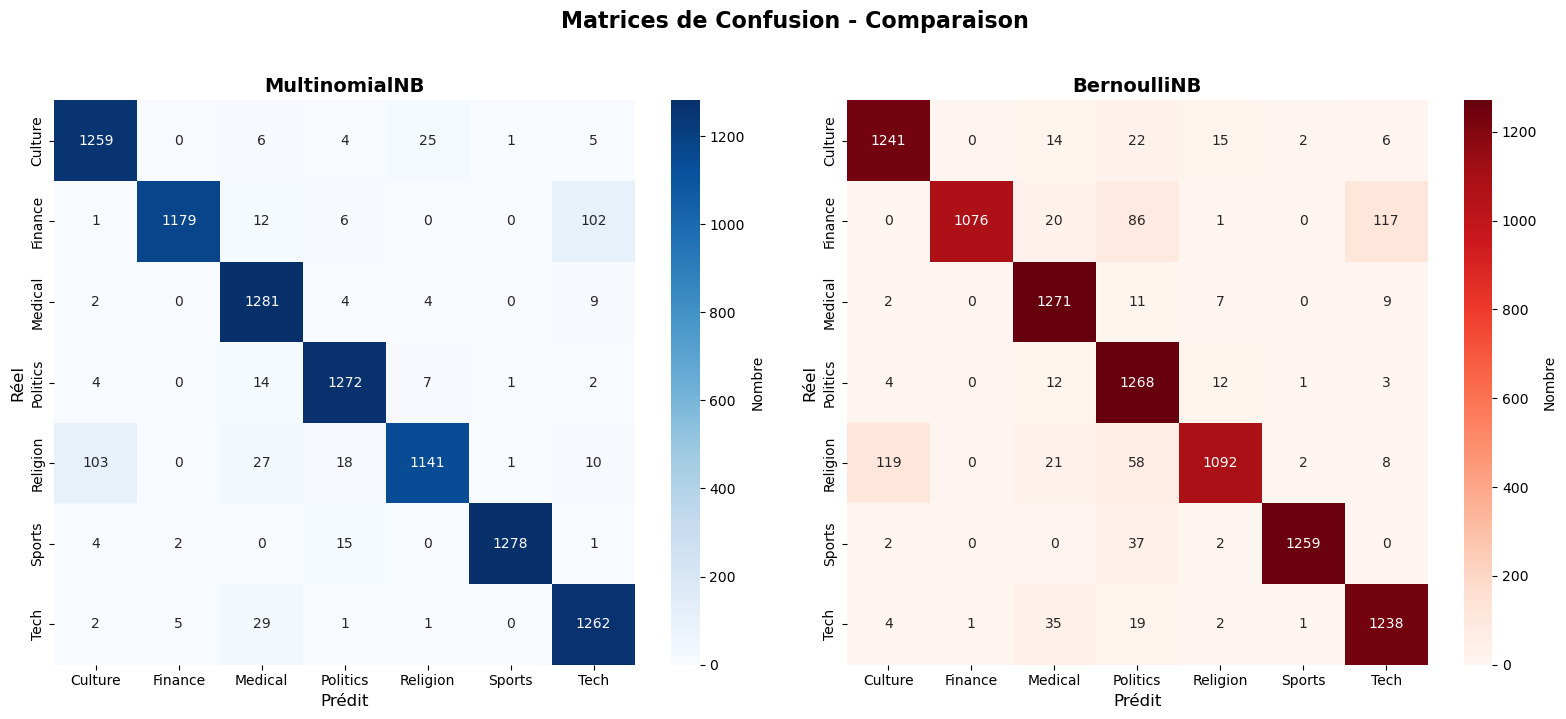

In [24]:
# ----------------------------
# 9. MATRICES DE CONFUSION
# ----------------------------
print(f"\n{'='*60}")
print("🎯 MATRICES DE CONFUSION")
print("="*60)

def plot_confusion_matrices_compact():
    """Matrices de confusion compactes."""
    classes = sorted(set(y_test))
    
    cm_mnb = confusion_matrix(y_test, y_pred_mnb, labels=classes)
    cm_bnb = confusion_matrix(y_test, y_pred_bnb, labels=classes)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # MultinomialNB
    sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                ax=axes[0], cbar_kws={'label': 'Nombre'})
    axes[0].set_title('MultinomialNB', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Prédit', fontsize=12)
    axes[0].set_ylabel('Réel', fontsize=12)
    
    # BernoulliNB
    sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Reds',
                xticklabels=classes, yticklabels=classes,
                ax=axes[1], cbar_kws={'label': 'Nombre'})
    axes[1].set_title('BernoulliNB', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Prédit', fontsize=12)
    axes[1].set_ylabel('Réel', fontsize=12)
    
    plt.suptitle('Matrices de Confusion - Comparaison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

plot_confusion_matrices_compact()


📊 VISUALISATION DES PERFORMANCES


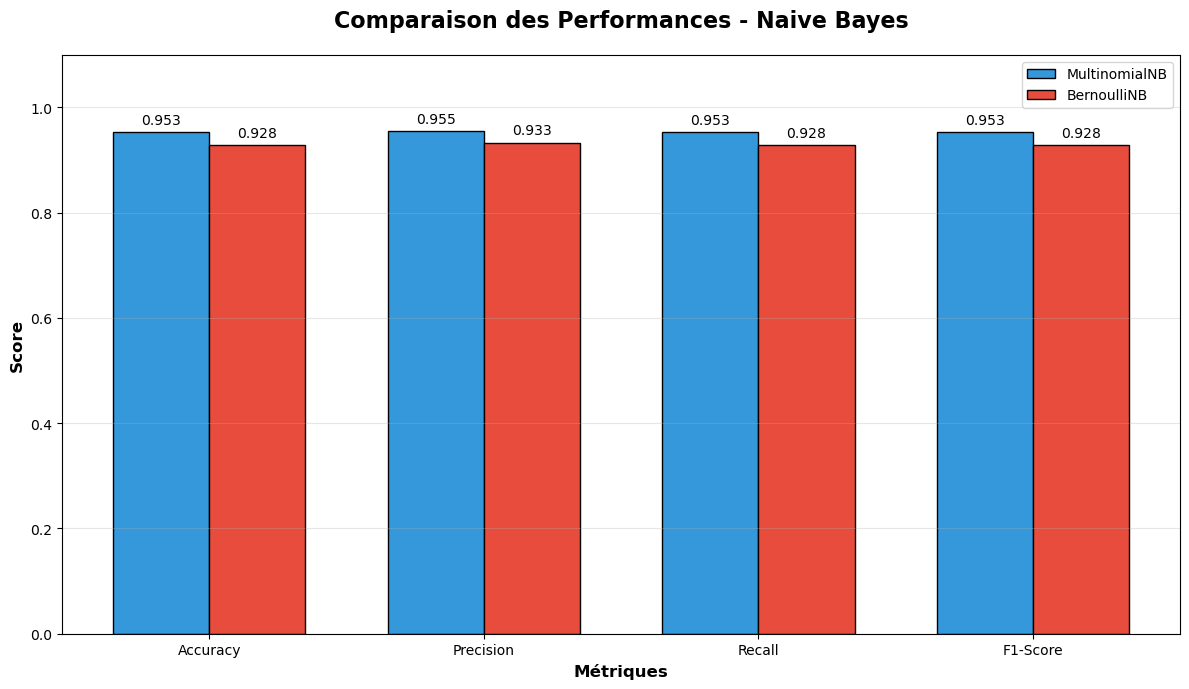

In [25]:

# ----------------------------
# 10. GRAPHIQUE DE COMPARAISON
# ----------------------------
print(f"\n{'='*60}")
print("📊 VISUALISATION DES PERFORMANCES")
print("="*60)

def plot_performance_comparison():
    """Graphique comparatif des performances."""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    mnb_scores = [accuracy_mnb, precision_mnb, recall_mnb, f1_mnb]
    bnb_scores = [accuracy_bnb, precision_bnb, recall_bnb, f1_bnb]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    bars1 = ax.bar(x - width/2, mnb_scores, width, label='MultinomialNB', 
                   color='#3498db', edgecolor='black')
    bars2 = ax.bar(x + width/2, bnb_scores, width, label='BernoulliNB', 
                   color='#e74c3c', edgecolor='black')
    
    ax.set_xlabel('Métriques', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Comparaison des Performances - Naive Bayes', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim([0, 1.1])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()

plot_performance_comparison()

In [26]:
# ----------------------------
# 11. EXEMPLES DE PRÉDICTIONS (SECTION CORRIGÉE)
# ----------------------------
print(f"\n{'='*60}")
print("🔮 EXEMPLES DE PRÉDICTIONS")
print("="*60)

# Prendre 3 exemples aléatoires
np.random.seed(42)
sample_indices = np.random.choice(len(y_test), 3, replace=False)

print("\n📋 Détails des prédictions:")
for i, idx in enumerate(sample_indices, 1):
    true_label = y_test[idx]
    pred_mnb = y_pred_mnb[idx]
    pred_bnb = y_pred_bnb[idx]
    
    # Probabilités
    proba_mnb = mnb_model.predict_proba(X_test[idx])[0]
    proba_bnb = bnb_model.predict_proba(X_test[idx])[0]
    
    true_idx_mnb = list(mnb_model.classes_).index(true_label)
    true_idx_bnb = list(bnb_model.classes_).index(true_label)
    
    confidence_mnb = proba_mnb[true_idx_mnb]
    confidence_bnb = proba_bnb[true_idx_bnb]
    
    print(f"\n{'─'*50}")
    print(f"Exemple {i}:")
    print(f"  Catégorie réelle: {true_label}")
    print(f"  MultinomialNB: {pred_mnb} ({'✓' if pred_mnb == true_label else '✗'}) - Confiance: {confidence_mnb:.2%}")
    print(f"  BernoulliNB:   {pred_bnb} ({'✓' if pred_bnb == true_label else '✗'}) - Confiance: {confidence_bnb:.2%}")
    
    # Afficher un extrait du texte (SANS la partie problématique)
    # Trouver l'index correspondant dans les données originales
    # (Ceci est optionnel - tu peux supprimer cette partie si tu veux)
    try:
        # Trouver le texte correspondant
        all_indices = list(range(len(y_test)))
        # Convertir y_test en numpy array pour le slicing
        y_test_array = np.array(y_test)
        # Trouver les indices où la catégorie correspond
        matching_indices = np.where(y_test_array == true_label)[0]
        if len(matching_indices) > 0:
            # Prendre le premier texte correspondant
            text_idx = matching_indices[0]
            if text_idx < len(cleaned_texts):
                text_preview = cleaned_texts[text_idx]
                preview = text_preview[:100] + "..." if len(text_preview) > 100 else text_preview
                print(f"  Texte (extrait): {preview}")
    except:
        pass  # Ignorer si ça ne marche pas


🔮 EXEMPLES DE PRÉDICTIONS

📋 Détails des prédictions:

──────────────────────────────────────────────────
Exemple 1:
  Catégorie réelle: Culture
  MultinomialNB: Culture (✓) - Confiance: 99.64%
  BernoulliNB:   Culture (✓) - Confiance: 100.00%
  Texte (extrait): تشارك دائره الثقافه والاعلام الشارقه معرض الجزائر الدولي للكتاب دورته السادسه عشره والتي انطلقت فعال...

──────────────────────────────────────────────────
Exemple 2:
  Catégorie réelle: Tech
  MultinomialNB: Tech (✓) - Confiance: 100.00%
  BernoulliNB:   Tech (✓) - Confiance: 100.00%
  Texte (extrait): ينظم معهد الشارقه للفنون معرضا فنيا عنوان باقه الفن، وذلك الساعه السابعه اليوم مقر المعهد منطقه الفن...

──────────────────────────────────────────────────
Exemple 3:
  Catégorie réelle: Religion
  MultinomialNB: Religion (✓) - Confiance: 100.00%
  BernoulliNB:   Religion (✓) - Confiance: 100.00%
  Texte (extrait): تتسمر امام الشاشه لساعات طويله وانت مبهور بالعاب الخفه الامريكيه الاحتفاء بكل جوانب الحياه، البرامج ...


In [27]:
# ----------------------------
# 12. SAUVEGARDE DES MODÈLES
# ----------------------------
print(f"\n{'='*60}")
print("💾 SAUVEGARDE DES FICHIERS")
print("="*60)

import joblib

# Sauvegarde des modèles
joblib.dump(mnb_model, 'C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/models/multinomial_nb.pkl')
joblib.dump(bnb_model, 'C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/models/bernoulli_nb.pkl')
joblib.dump(vectorizer, 'C:/Users/SAFAE ERAJI/Desktop/arabic_documents_classification/vectorizer/tfidf_vectorizer.pkl')

print("✅ Fichiers sauvegardés :")
print("   1. multinomial_nb.pkl")
print("   2. bernoulli_nb.pkl")
print("   3. tfidf_vectorizer.pkl")


💾 SAUVEGARDE DES FICHIERS
✅ Fichiers sauvegardés :
   1. multinomial_nb.pkl
   2. bernoulli_nb.pkl
   3. tfidf_vectorizer.pkl


In [28]:
# ----------------------------
# 13. RÉSUMÉ FINAL
# ----------------------------
print(f"\n{'='*60}")
print("🎉 RÉSUMÉ DU PROJET")
print("="*60)

total_time = load_time + preprocess_time + tfidf_time + total_train_time

print(f"\n📊 PERFORMANCE FINALE:")
print(f"   MultinomialNB Accuracy: {accuracy_mnb:.2%}")
print(f"   BernoulliNB Accuracy:   {accuracy_bnb:.2%}")
print(f"   Meilleur modèle: {'MultinomialNB' if accuracy_mnb > accuracy_bnb else 'BernoulliNB'}")

print(f"\n⏱️  TEMPS D'EXÉCUTION:")
print(f"   Chargement:     {load_time:.1f}s")
print(f"   Prétraitement:  {preprocess_time:.1f}s")
print(f"   TF-IDF:         {tfidf_time:.1f}s")
print(f"   Entraînement:   {total_train_time:.1f}s")
print(f"   {'─'*30}")
print(f"   TOTAL:          {total_time:.1f}s")

print(f"\n📁 DONNÉES:")
print(f"   Documents:      {len(texts):,}")
print(f"   Catégories:     7")
print(f"   Features TF-IDF: {X.shape[1]:,}")
print(f"   Train/Test:     {X_train.shape[0]:,}/{X_test.shape[0]:,}")

print(f"\n✅ PROJET TERMINÉ AVEC SUCCÈS!")
print(f"{'='*60}")


🎉 RÉSUMÉ DU PROJET

📊 PERFORMANCE FINALE:
   MultinomialNB Accuracy: 95.30%
   BernoulliNB Accuracy:   92.80%
   Meilleur modèle: MultinomialNB

⏱️  TEMPS D'EXÉCUTION:
   Chargement:     14.0s
   Prétraitement:  26.0s
   TF-IDF:         82.0s
   Entraînement:   0.3s
   ──────────────────────────────
   TOTAL:          122.2s

📁 DONNÉES:
   Documents:      45,498
   Catégories:     7
   Features TF-IDF: 10,000
   Train/Test:     36,398/9,100

✅ PROJET TERMINÉ AVEC SUCCÈS!
